AutoGluon - Predicción de ventas (tn) por producto para febrero 2020

In [38]:
# 📦 1. Importar librerías
import pandas as pd
import numpy as np

In [39]:
# 💬 Instalar AutoGluon si es necesario
#%pip install autogluon.timeseries

from autogluon.timeseries import TimeSeriesPredictor, TimeSeriesDataFrame
from sklearn.preprocessing import StandardScaler

In [40]:
# 📄 2. Cargar datasets
df_sellin = pd.read_csv("../data/sell-in.txt", sep="\t")
df_productos = pd.read_csv("../data/tb_productos.txt", sep="\t")

In [41]:
# 📄 Leer lista de productos a predecir
with open("../data/product_id_apredecir201912.txt", "r") as f:
    product_ids = [int(line.strip()) for line in f if line.strip().isdigit()]

In [42]:
# 🧹 3. Preprocesamiento
# Convertir periodo a datetime
df_sellin['timestamp'] = pd.to_datetime(df_sellin['periodo'], format='%Y%m')

In [43]:
# Filtrar hasta dic 2019 y productos requeridos
df_filtered = df_sellin[
    (df_sellin['timestamp'] <= '2019-12-01') &
    (df_sellin['product_id'].isin(product_ids))
]

In [44]:
# Agregar tn por periodo, cliente y producto
df_grouped = df_filtered.groupby(['timestamp', 'customer_id', 'product_id'], as_index=False)['tn'].sum()

In [45]:
# Agregar tn total por periodo y producto
df_monthly_product = df_grouped.groupby(['timestamp', 'product_id'], as_index=False)['tn'].sum()

In [46]:
# Agregar columna 'item_id' para AutoGluon
df_monthly_product['item_id'] = df_monthly_product['product_id']

In [47]:
# # Crear características de lag y rolling
# for lag in [1, 3, 6, 12, 18]:
#     df_monthly_product[f'tn_lag_{lag}'] = df_monthly_product.groupby('product_id')['tn'].shift(lag)

# df_monthly_product['tn_rolling_mean_3'] = df_monthly_product.groupby('product_id')['tn'].shift(1).rolling(window=3).mean()
# df_monthly_product['tn_rolling_std_3'] = df_monthly_product.groupby('product_id')['tn'].shift(1).rolling(window=3).std()

# df_monthly_product['tn_rolling_mean_6'] = df_monthly_product.groupby('product_id')['tn'].shift(1).rolling(window=6).mean()
# df_monthly_product['tn_rolling_std_6'] = df_monthly_product.groupby('product_id')['tn'].shift(1).rolling(window=6).std()

# # Diferencia absoluta de tn respecto al mes anterior y mismo mes del año anterior
# df_monthly_product['tn_diff_1']   = df_monthly_product['tn'] - df_monthly_product['tn_lag_1']
# df_monthly_product['tn_diff_12']  = df_monthly_product['tn'] - df_monthly_product['tn_lag_12']

# df_monthly_product['tn_pctchg_1']  = df_monthly_product['tn'].pct_change(periods=1)
# df_monthly_product['tn_pctchg_12'] = df_monthly_product['tn'].pct_change(periods=12)

# # Medias/desviaciones de ventana 9 y 18 meses
# df_monthly_product['tn_roll_mean_9'] = (
#     df_monthly_product
#       .groupby('product_id')['tn']
#       .shift(1)
#       .rolling(window=9).mean()
# )
# df_monthly_product['tn_roll_std_9'] = (
#     df_monthly_product
#       .groupby('product_id')['tn']
#       .shift(1)
#       .rolling(window=9).std()
# )
# df_monthly_product['tn_roll_mean_18'] = (
#     df_monthly_product
#       .groupby('product_id')['tn']
#       .shift(1)
#       .rolling(window=18).mean()
# )
# df_monthly_product['tn_roll_std_18'] = (
#     df_monthly_product
#       .groupby('product_id')['tn']
#       .shift(1)
#       .rolling(window=18).std()
# )

# df_monthly_product['tn_expanding_mean'] = (
#     df_monthly_product
#       .groupby('product_id')['tn']
#       .expanding(min_periods=1).mean()
#       .reset_index(level=0, drop=True)
# )
# df_monthly_product['tn_expanding_std'] = (
#     df_monthly_product
#       .groupby('product_id')['tn']
#       .expanding(min_periods=1).std()
#       .reset_index(level=0, drop=True)
# )

# df_monthly_product['tn_ewm_0.3'] = (
#     df_monthly_product
#       .groupby('product_id')['tn']
#       .apply(lambda x: x.shift(1).ewm(alpha=0.3).mean())
# )

# df_monthly_product['month_sin'] = np.sin(2 * np.pi * df_monthly_product['timestamp'].dt.month/12)
# df_monthly_product['month_cos'] = np.cos(2 * np.pi * df_monthly_product['timestamp'].dt.month/12)

# df_monthly_product['tn_yoy_diff']  = df_monthly_product['tn'] - df_monthly_product['tn_lag_12']
# df_monthly_product['tn_yoy_rate']  = df_monthly_product['tn_yoy_diff'] / (df_monthly_product['tn_lag_12'] + 1e-6)

# # p.ej. promedio de tn por categoría de producto (“cat1”)
# df_monthly_product['cat1_tn_mean'] = (
#     df_monthly_product
#       .groupby(['timestamp','cat1'])['tn']
#       .transform('mean')
# )

# # Ejemplo: encoding de brand × lag
# df_monthly_product['brand_lag1'] = (
#     df_monthly_product['brand'].astype('category').cat.codes *
#     df_monthly_product['tn_lag_1']
# )

# Asume que ya tienes df_monthly_product, con índice estándar (RangeIndex)

# 1) Lags de tn
for lag in [1, 3, 6, 12, 18]:
    df_monthly_product[f'tn_lag_{lag}'] = df_monthly_product.groupby('product_id')['tn'] \
                                                      .transform(lambda x, l=lag: x.shift(l))

# 2) Rolling mean/std
df_monthly_product['tn_rolling_mean_3'] = df_monthly_product.groupby('product_id')['tn'] \
                                                            .transform(lambda x: x.shift(1).rolling(3).mean())
df_monthly_product['tn_rolling_std_3']  = df_monthly_product.groupby('product_id')['tn'] \
                                                            .transform(lambda x: x.shift(1).rolling(3).std())

df_monthly_product['tn_rolling_mean_6'] = df_monthly_product.groupby('product_id')['tn'] \
                                                            .transform(lambda x: x.shift(1).rolling(6).mean())
df_monthly_product['tn_rolling_std_6']  = df_monthly_product.groupby('product_id')['tn'] \
                                                            .transform(lambda x: x.shift(1).rolling(6).std())

# 3) Diferencias y pct change (por producto)
df_monthly_product['tn_diff_1']   = df_monthly_product.groupby('product_id')['tn'] \
                                                      .transform(lambda x: x - x.shift(1))
df_monthly_product['tn_diff_12']  = df_monthly_product.groupby('product_id')['tn'] \
                                                      .transform(lambda x: x - x.shift(12))

df_monthly_product['tn_pctchg_1']  = df_monthly_product.groupby('product_id')['tn'] \
                                                       .transform(lambda x: x.pct_change(1))
df_monthly_product['tn_pctchg_12'] = df_monthly_product.groupby('product_id')['tn'] \
                                                       .transform(lambda x: x.pct_change(12))

# 4) Rolling ventana 9 y 18
for window in [9, 18]:
    df_monthly_product[f'tn_roll_mean_{window}'] = df_monthly_product.groupby('product_id')['tn'] \
                                                                  .transform(lambda x, w=window: x.shift(1).rolling(w).mean())
    df_monthly_product[f'tn_roll_std_{window}']  = df_monthly_product.groupby('product_id')['tn'] \
                                                                  .transform(lambda x, w=window: x.shift(1).rolling(w).std())

# 5) Expanding stats
df_monthly_product['tn_expanding_mean'] = df_monthly_product.groupby('product_id')['tn'] \
                                                              .transform(lambda x: x.expanding(1).mean())
df_monthly_product['tn_expanding_std']  = df_monthly_product.groupby('product_id')['tn'] \
                                                              .transform(lambda x: x.expanding(1).std())

# 6) EWMA
df_monthly_product['tn_ewm_0.3'] = df_monthly_product.groupby('product_id')['tn'] \
                                                        .transform(lambda x: x.shift(1).ewm(alpha=0.3).mean())

# 7) Códigos cíclicos de mes
df_monthly_product['month_sin'] = np.sin(2 * np.pi * df_monthly_product['timestamp'].dt.month / 12)
df_monthly_product['month_cos'] = np.cos(2 * np.pi * df_monthly_product['timestamp'].dt.month / 12)

# 8) YoY diff & rate
df_monthly_product['tn_yoy_diff'] = df_monthly_product.groupby('product_id')['tn'] \
                                                        .transform(lambda x: x - x.shift(12))
df_monthly_product['tn_yoy_rate'] = df_monthly_product['tn_yoy_diff'] / \
                                   (df_monthly_product.groupby('product_id')['tn'] \
                                                      .transform(lambda x: x.shift(12)) + 1e-6)



In [48]:
df_monthly_product

,timestamp,product_id,tn,item_id,tn_lag_1,tn_lag_3,tn_lag_6,tn_lag_12,tn_lag_18,tn_rolling_mean_3,...,tn_roll_std_9,tn_roll_mean_18,tn_roll_std_18,tn_expanding_mean,tn_expanding_std,tn_ewm_0.3,month_sin,month_cos,tn_yoy_diff,tn_yoy_rate
0,2017-01-01,20001,934.77222,20001,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,934.772220,NaN,NaN,5.000000e-01,0.866025,NaN,NaN
1,2017-01-01,20002,550.15707,20002,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,550.157070,NaN,NaN,5.000000e-01,0.866025,NaN,NaN
2,2017-01-01,20003,1063.45835,20003,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1063.458350,NaN,NaN,5.000000e-01,0.866025,NaN,NaN
3,2017-01-01,20004,555.91614,20004,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,555.916140,NaN,NaN,5.000000e-01,0.866025,NaN,NaN
4,2017-01-01,20005,494.27011,20005,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,494.270110,NaN,NaN,5.000000e-01,0.866025,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22344,2019-12-01,21263,0.01270,21263,0.03247,0.01128,0.00988,0.06068,NaN,0.019757,...,0.017464,NaN,NaN,0.089233,0.153381,0.028276,-2.449294e-16,1.000000,-0.04798,-0.790692
22345,2019-12-01,21265,0.05007,21265,0.06600,0.01707,0.05121,NaN,NaN,0.064093,...,0.114462,NaN,NaN,0.089541,0.108803,0.069911,-2.449294e-16,1.000000,NaN,NaN
22346,2019-12-01,21266,0.05121,21266,0.06713,0.02844,0.05235,NaN,NaN,0.071293,...,0.111224,NaN,NaN,0.094659,0.105968,0.076117,-2.449294e-16,1.000000,NaN,NaN
22347,2019-12-01,21267,0.01569,21267,0.04052,0.01830,0.05882,NaN,NaN,0.051860,...,0.079764,NaN,NaN,0.092835,0.079939,0.065721,-2.449294e-16,1.000000,NaN,NaN


In [ ]:
ipc_ar = pd.read_csv('../data/IPC-AR_export.csv', sep=',', encoding='utf-8')
# convertir 'periodo' a datetime first-of-month
ipc_ar['periodo'] = pd.to_datetime(ipc_ar['periodo'], format='%m-%Y').dt.to_period('M').dt.to_timestamp()
ipc_ar = ipc_ar.rename(columns={'indice_ipc':'ipc'})
# rellenar na de var_anual
first_real = ipc_ar['var_anual'].dropna().iloc[0]
ipc_ar['var_anual'] = ipc_ar['var_anual'].fillna(first_real)

# Merge IPC
df_monthly_product = df_monthly_product.merge(
    ipc_ar[['periodo','ipc','var_mensual','var_anual']],
    left_on='timestamp',
    right_on='periodo',
    how='left'
).drop(columns=['periodo'])


# 2) Cotización del dólar
df_dolar = pd.read_csv('../data/cotizacionDolar.csv', sep=',', encoding='utf-8')
# fecha → periodo (first-of-month)
df_dolar['fecha'] = pd.to_datetime(df_dolar['fecha'], format='%m/%d/%Y')
df_dolar['periodo'] = df_dolar['fecha'].dt.to_period('M').dt.to_timestamp()
# promedio mensual de venta
df_dolar_resum = (
    df_dolar
    .groupby('periodo', as_index=False)
    .agg(promedio_mens_dolar_venta=('cotizacion_dolar_venta','mean'))
)
# Merge Dólar
df_monthly_product = df_monthly_product.merge(
    df_dolar_resum[['periodo','promedio_mens_dolar_venta']],
    left_on='timestamp',
    right_on='periodo',
    how='left'
).drop(columns=['periodo'])

In [50]:
df_monthly_product

,timestamp,product_id,tn,item_id,tn_lag_1,tn_lag_3,tn_lag_6,tn_lag_12,tn_lag_18,tn_rolling_mean_3,...,tn_expanding_std,tn_ewm_0.3,month_sin,month_cos,tn_yoy_diff,tn_yoy_rate,ipc,var_mensual,var_anual,promedio_mens_dolar_venta
0,2017-01-01,20001,934.77222,20001,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.000000e-01,0.866025,NaN,NaN,101.5859,1.59,24.80,15.909273
1,2017-01-01,20002,550.15707,20002,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.000000e-01,0.866025,NaN,NaN,101.5859,1.59,24.80,15.909273
2,2017-01-01,20003,1063.45835,20003,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.000000e-01,0.866025,NaN,NaN,101.5859,1.59,24.80,15.909273
3,2017-01-01,20004,555.91614,20004,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.000000e-01,0.866025,NaN,NaN,101.5859,1.59,24.80,15.909273
4,2017-01-01,20005,494.27011,20005,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.000000e-01,0.866025,NaN,NaN,101.5859,1.59,24.80,15.909273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22344,2019-12-01,21263,0.01270,21263,0.03247,0.01128,0.00988,0.06068,NaN,0.019757,...,0.153381,0.028276,-2.449294e-16,1.000000,-0.04798,-0.790692,283.4442,3.74,53.83,59.875550
22345,2019-12-01,21265,0.05007,21265,0.06600,0.01707,0.05121,NaN,NaN,0.064093,...,0.108803,0.069911,-2.449294e-16,1.000000,NaN,NaN,283.4442,3.74,53.83,59.875550
22346,2019-12-01,21266,0.05121,21266,0.06713,0.02844,0.05235,NaN,NaN,0.071293,...,0.105968,0.076117,-2.449294e-16,1.000000,NaN,NaN,283.4442,3.74,53.83,59.875550
22347,2019-12-01,21267,0.01569,21267,0.04052,0.01830,0.05882,NaN,NaN,0.051860,...,0.079939,0.065721,-2.449294e-16,1.000000,NaN,NaN,283.4442,3.74,53.83,59.875550


In [57]:
# 3) Temperaturas históricas
df_temp = pd.read_csv('../data/temperaturaMediaHistoricaCABA.csv', sep=',', encoding='utf-8')
# si falta temp_media, aproximar con (max+min)/2
df_temp['temp_media'] = df_temp['temp_media'].fillna(
    (df_temp['temp_max_media'] + df_temp['temp_min_media'])/2
)
# convertir periodo a timestamp first-of-month
df_temp['periodo_fecha'] = pd.to_datetime(df_temp['periodo_fecha'], format='%b-%y')

df_temp['periodo'] = df_temp['periodo_fecha'].dt.strftime('%Y-%m-01')
# rellenar temp_media faltantes
df_temp['temp_media'] = df_temp['temp_media'].fillna(
    (df_temp['temp_max_media'] + df_temp['temp_min_media'])/2
)
df_temp

,periodo_fecha,temp_media,temp_max_media,temp_min_media,periodo
0,2017-01-01,25.65,30.4,20.9,2017-01-01
1,2017-02-01,25.35,30.1,20.6,2017-02-01
2,2017-03-01,22.45,26.9,18.0,2017-03-01
3,2017-04-01,18.90,23.5,14.3,2017-04-01
4,2017-05-01,15.90,19.5,12.3,2017-05-01
5,2017-06-01,13.70,17.9,9.5,2017-06-01
6,2017-07-01,13.35,17.0,9.7,2017-07-01
7,2017-08-01,15.15,19.2,11.1,2017-08-01
8,2017-09-01,15.95,20.3,11.6,2017-09-01
9,2017-10-01,17.15,23.0,11.3,2017-10-01


In [58]:
# 3) Temperaturas históricas
df_temp = pd.read_csv('../data/temperaturaMediaHistoricaCABA.csv', sep=',', encoding='utf-8')
# si falta temp_media, aproximar con (max+min)/2
df_temp['temp_media'] = df_temp['temp_media'].fillna(
    (df_temp['temp_max_media'] + df_temp['temp_min_media'])/2
)
# convertir periodo a timestamp first-of-month
df_temp['periodo_fecha'] = pd.to_datetime(df_temp['periodo_fecha'], format='%b-%y')

df_temp['periodo'] = df_temp['periodo_fecha'].dt.strftime('%Y-%m-01')
# rellenar temp_media faltantes
df_temp['temp_media'] = df_temp['temp_media'].fillna(
    (df_temp['temp_max_media'] + df_temp['temp_min_media'])/2
)

df_temp['periodo'] = pd.to_datetime(df_temp['periodo'], format='%Y-%m-%d')
df_temp['periodo'] = df_temp['periodo'].dt.to_period('M').dt.to_timestamp()
# Merge Temperaturas
df_monthly_product = df_monthly_product.merge(
    df_temp[['periodo','temp_media','temp_max_media','temp_min_media']],
    left_on='timestamp',
    right_on='periodo',
    how='left'
).drop(columns=['periodo'])

In [59]:
df_monthly_product

,timestamp,product_id,tn,item_id,tn_lag_1,tn_lag_3,tn_lag_6,tn_lag_12,tn_lag_18,tn_rolling_mean_3,...,month_cos,tn_yoy_diff,tn_yoy_rate,ipc,var_mensual,var_anual,promedio_mens_dolar_venta,temp_media,temp_max_media,temp_min_media
0,2017-01-01,20001,934.77222,20001,NaN,NaN,NaN,NaN,NaN,NaN,...,0.866025,NaN,NaN,101.5859,1.59,24.80,15.909273,25.65,30.4,20.9
1,2017-01-01,20002,550.15707,20002,NaN,NaN,NaN,NaN,NaN,NaN,...,0.866025,NaN,NaN,101.5859,1.59,24.80,15.909273,25.65,30.4,20.9
2,2017-01-01,20003,1063.45835,20003,NaN,NaN,NaN,NaN,NaN,NaN,...,0.866025,NaN,NaN,101.5859,1.59,24.80,15.909273,25.65,30.4,20.9
3,2017-01-01,20004,555.91614,20004,NaN,NaN,NaN,NaN,NaN,NaN,...,0.866025,NaN,NaN,101.5859,1.59,24.80,15.909273,25.65,30.4,20.9
4,2017-01-01,20005,494.27011,20005,NaN,NaN,NaN,NaN,NaN,NaN,...,0.866025,NaN,NaN,101.5859,1.59,24.80,15.909273,25.65,30.4,20.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22344,2019-12-01,21263,0.01270,21263,0.03247,0.01128,0.00988,0.06068,NaN,0.019757,...,1.000000,-0.04798,-0.790692,283.4442,3.74,53.83,59.875550,24.00,29.5,18.0
22345,2019-12-01,21265,0.05007,21265,0.06600,0.01707,0.05121,NaN,NaN,0.064093,...,1.000000,NaN,NaN,283.4442,3.74,53.83,59.875550,24.00,29.5,18.0
22346,2019-12-01,21266,0.05121,21266,0.06713,0.02844,0.05235,NaN,NaN,0.071293,...,1.000000,NaN,NaN,283.4442,3.74,53.83,59.875550,24.00,29.5,18.0
22347,2019-12-01,21267,0.01569,21267,0.04052,0.01830,0.05882,NaN,NaN,0.051860,...,1.000000,NaN,NaN,283.4442,3.74,53.83,59.875550,24.00,29.5,18.0


In [60]:
# Incorporar características estáticas de tb_productos
df_monthly_product = df_monthly_product.merge(df_productos, on='product_id', how='left')

# Normalizar características numéricas
scaler = StandardScaler()
numeric_cols = ['tn_lag_1', 'tn_lag_3', 'tn_lag_6', 'tn_lag_12', 'tn_lag_18', 
                'tn_rolling_mean_3', 'tn_rolling_std_3', 'tn_rolling_mean_6', 'tn_rolling_std_6',
                'tn_diff_1', 'tn_diff_12', 'tn_pctchg_1', 'tn_pctchg_12',
                'tn_roll_mean_9', 'tn_roll_std_9', 'tn_roll_mean_18', 'tn_roll_std_18',
                'tn_expanding_mean', 'tn_expanding_std', 'tn_ewm_0.3',
                'month_sin', 'month_cos', 'tn_yoy_diff', 'tn_yoy_rate',
                'ipc', 'var_mensual', 'var_anual', 'promedio_mens_dolar_venta',
                'temp_media', 'temp_max_media', 'temp_min_media']
df_monthly_product[numeric_cols] = scaler.fit_transform(df_monthly_product[numeric_cols].fillna(0))

In [61]:
df_monthly_product

,timestamp,product_id,tn,item_id,tn_lag_1,tn_lag_3,tn_lag_6,tn_lag_12,tn_lag_18,tn_rolling_mean_3,...,var_anual,promedio_mens_dolar_venta,temp_media,temp_max_media,temp_min_media,cat1,cat2,cat3,brand,sku_size
0,2017-01-01,20001,934.77222,20001,-0.404361,-0.391227,-0.369555,-0.322445,-0.281481,-0.396736,...,-1.080983,-1.149907,1.497306,1.401407,1.582684,HC,ROPA LAVADO,Liquido,ARIEL,3000
1,2017-01-01,20002,550.15707,20002,-0.404361,-0.391227,-0.369555,-0.322445,-0.281481,-0.396736,...,-1.080983,-1.149907,1.497306,1.401407,1.582684,HC,ROPA LAVADO,Liquido,LIMPIEX,3000
2,2017-01-01,20003,1063.45835,20003,-0.404361,-0.391227,-0.369555,-0.322445,-0.281481,-0.396736,...,-1.080983,-1.149907,1.497306,1.401407,1.582684,FOODS,ADEREZOS,Mayonesa,NATURA,475
3,2017-01-01,20004,555.91614,20004,-0.404361,-0.391227,-0.369555,-0.322445,-0.281481,-0.396736,...,-1.080983,-1.149907,1.497306,1.401407,1.582684,FOODS,ADEREZOS,Mayonesa,NATURA,240
4,2017-01-01,20005,494.27011,20005,-0.404361,-0.391227,-0.369555,-0.322445,-0.281481,-0.396736,...,-1.080983,-1.149907,1.497306,1.401407,1.582684,FOODS,ADEREZOS,Mayonesa,NATURA,120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22677,2019-12-01,21263,0.01270,21263,-0.404105,-0.391136,-0.369472,-0.321898,-0.281481,-0.396574,...,1.102322,1.791815,1.142437,1.223291,0.873478,PC,CABELLO,SHAMPOO,VICHY,250
22678,2019-12-01,21265,0.05007,21265,-0.403841,-0.391089,-0.369126,-0.322445,-0.281481,-0.396209,...,1.102322,1.791815,1.142437,1.223291,0.873478,PC,PIEL1,CUIDADO ESPECIAL,LANCOME,32
22679,2019-12-01,21266,0.05121,21266,-0.403832,-0.390996,-0.369116,-0.322445,-0.281481,-0.396150,...,1.102322,1.791815,1.142437,1.223291,0.873478,PC,PIEL1,CUIDADO ESPECIAL,LANCOME,32
22680,2019-12-01,21267,0.01569,21267,-0.404042,-0.391079,-0.369062,-0.322445,-0.281481,-0.396310,...,1.102322,1.791815,1.142437,1.223291,0.873478,PC,PIEL1,Cara,NIVEA,250


In [62]:
df_prod_static = (
    df_productos
    .rename(columns={'product_id': 'item_id'})
    .drop_duplicates(subset=['item_id'])
)  # dejamos item_id como columna

ts_data = TimeSeriesDataFrame.from_data_frame(
    df_monthly_product,
    id_column='item_id',
    timestamp_column='timestamp',
    static_features_df=df_prod_static
)


# # ⏰ 4. Crear TimeSeriesDataFrame
# ts_data = TimeSeriesDataFrame.from_data_frame(
#     df_monthly_product,
#     id_column='item_id',
#     timestamp_column='timestamp'
# )

In [63]:
# # Completar valores faltantes
ts_data = ts_data.fill_missing_values()

In [64]:
predictor = TimeSeriesPredictor(
    prediction_length=2,
    target='tn',
    freq='MS',
    eval_metric='WQL'
)

predictor.fit(
    train_data=ts_data,
    num_val_windows=2,
    time_limit=60*60
)

Beginning AutoGluon training... Time limit = 3600s
AutoGluon will save models to 'c:\Users\leona\source\repos\lab3\notebooks\AutogluonModels\ag-20250715_020430'
=================== System Info ===================
AutoGluon Version:  1.3.1
Python Version:     3.10.17
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.26100
CPU Count:          12
GPU Count:          0
Memory Avail:       8.45 GB / 31.71 GB (26.7%)
Disk Space Avail:   200.34 GB / 952.62 GB (21.0%)

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'MS',
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 2,
 'prediction_length': 2,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'tn',
 'time_limit': 3600,
 'verbosity': 2}

train_data with frequency 'IRREG' has been resampled to frequency 'MS'.
Provided t

In [65]:
# 3.1) Sólo data como argumento
future_template = predictor.make_future_data_frame(ts_data)

# 3.2) Covariables “a mano”
future_rows = []
for item_id in product_ids:
    last = df_monthly_product[df_monthly_product['item_id']==item_id].iloc[-1]
    future_rows.append({
        'item_id': item_id,
        'timestamp': pd.Timestamp('2020-02-01'),
        'month':  2,
        'year':   2020,
        'tn_lag_1':          last['tn_lag_1'],
        'tn_lag_3':          last['tn_lag_3'],
        'tn_lag_6':          last['tn_lag_6'],
        'tn_lag_12':         last['tn_lag_12'],
        'tn_lag_18':         last['tn_lag_18'],
        'tn_rolling_mean_3': last['tn_rolling_mean_3'],
        'tn_rolling_std_3':  last['tn_rolling_std_3'],
        'tn_rolling_mean_6': last['tn_rolling_mean_6'],
        'tn_rolling_std_6':  last['tn_rolling_std_6'],
        'tn_diff_1': last['tn_diff_1'], 
        'tn_diff_12': last['tn_diff_1'], 
        'tn_pctchg_1': last['tn_pctchg_1'], 
        'tn_pctchg_12': last['tn_pctchg_1'],
        'tn_roll_mean_9': last['tn_roll_mean_9'], 
        'tn_roll_std_9': last['tn_roll_mean_9'], 
        'tn_roll_mean_18': last['tn_roll_mean_9'], 
        'tn_roll_std_18': last['tn_roll_mean_9'],
        'tn_expanding_mean': last['tn_expanding_mean'], 
        'tn_expanding_std': last['tn_expanding_mean'], 
        'tn_ewm_0.3': last['tn_ewm_0.3'],
        'month_sin': last['month_sin'], 
        'month_cos': last['month_sin'], 
        'tn_yoy_diff': last['tn_yoy_diff'], 
        'tn_yoy_rate': last['tn_yoy_rate'],
        'ipc': last['ipc'],
        'var_mensual': last['var_mensual'],
        'var_anual': last['var_anual'],
        'promedio_mens_dolar_venta': last['promedio_mens_dolar_venta'],
        'temp_media': last['temp_media'],
        'temp_max_media': last['temp_max_media'],
        'temp_min_media': last['temp_min_media']     
    })
df_future_covars = pd.DataFrame(future_rows)

# 3.3) Merge plantilla + covariables
future_covars = future_template.merge(
    df_future_covars,
    on=['item_id','timestamp'],
    how='left'
)

# 3.4) A TimeSeriesDataFrame
ts_future_covars = TimeSeriesDataFrame.from_data_frame(
    future_covars,
    id_column='item_id',
    timestamp_column='timestamp'
).fill_missing_values(method='ffill', value=0)

data with frequency 'IRREG' has been resampled to frequency 'MS'.


In [66]:
# # 🔮 6. Generar predicción
# forecast = predictor.predict(ts_data)

# 4) Predecir
forecast = predictor.predict(
    data=ts_data,
    known_covariates=ts_future_covars
)

data with frequency 'IRREG' has been resampled to frequency 'MS'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


In [67]:
forecast

mean         0.1          0.2          0.3  \
item_id timestamp                                                       
20001   2020-01-01  1264.884077  886.647709  1010.738924  1129.275068   
        2020-02-01  1303.631371  896.080660  1052.095503  1143.834557   
20002   2020-01-01  1104.451440  726.243359   847.253082   970.015436   
        2020-02-01  1052.922860  668.237586   806.942258   891.004874   
20003   2020-01-01   766.780462  538.625969   618.382930   665.818951   
...                         ...         ...          ...          ...   
20995   2020-02-01     2.500369    0.559149     1.263175     1.729095   
21087   2020-01-01     0.899825    0.392346     0.572631     0.703834   
        2020-02-01     0.915960    0.322349     0.538869     0.679404   
21214   2020-01-01     0.348200   -0.002678     0.117994     0.205754   
        2020-02-01     0.338877   -0.104313     0.051171     0.162360   

                            0.4          0.5          0.6          0.7  \
item_id timestamp                                                        
20001   2020-01-01  1194.612336  1263.139884  1342.207897  1413.027389   
        2020-02-01  1217.178690  1306.915454  1381.079203  1458.878690   
20002   2020-01-01  1032.534191  1126.403013  1188.171558  1258.283959   
        2020-02-01   965.567922  1039.759685  1144.887390  1220.321587   
20003   2020-01-01   716.421823   761.278340   804.244741   853.269058   
...                         ...          ...          ...          ...   
20995   2020-02-01     2.119303     2.494532     2.898898     3.323368   
21087   2020-01-01     0.801769     0.898108     0.989160     1.100183   
        2020-02-01     0.784670     0.909846     1.023743     1.154602   
21214   2020-01-01     0.277528     0.347006     0.413781     0.489710   
        2020-02-01     0.254656     0.347955     0.431001     0.524924   

                            0.8          0.9  
item_id timestamp                             
20001   2020-01-01  1507.530364  1639.020959  
        2020-02-01  1575.068295  1726.409977  
20002   2020-01-01  1352.580269  1468.700086  
        2020-02-01  1317.314985  1459.973104  
20003   2020-01-01   912.871411  1012.314465  
...                         ...          ...  
20995   2020-02-01     3.833474     4.675897  
21087   2020-01-01     1.225354     1.416666  
        2020-02-01     1.311824     1.556071  
21214   2020-01-01     0.593895     0.752682  
        2020-02-01     0.657041     0.841278  

[1560 rows x 10 columns]

In [68]:
predictor.leaderboard(ts_data)

data with frequency 'IRREG' has been resampled to frequency 'MS'.
Additional data provided, testing on additional data. Resulting leaderboard will be sorted according to test score (`score_test`).


,model,score_test,score_val,pred_time_test,pred_time_val,fit_time_marginal,fit_order
0,ChronosFineTuned[bolt_small],-0.185882,-0.179801,1.232734,0.757457,521.238108,8
1,WeightedEnsemble,-0.189336,-0.171345,11.047122,6.832440,2.172362,13
2,TemporalFusionTransformer,-0.194514,-0.185021,0.723393,0.900068,274.023530,9
3,PatchTST,-0.209386,-0.186348,0.322945,0.235126,63.075582,11
4,ChronosZeroShot[bolt_base],-0.211922,-0.190460,4.465323,3.686667,10.635934,7
5,AutoETS,-0.215147,-0.201045,2.887390,2.887908,2.870918,6
6,DeepAR,-0.215483,-0.181887,0.766729,0.597776,135.034323,10
7,DynamicOptimizedTheta,-0.221798,-0.203868,2.043604,0.649554,2.665517,5
8,DirectTabular,-0.223213,-0.227987,0.649324,0.547785,39.311913,3
9,RecursiveTabular,-0.228650,-0.213785,0.107281,0.080675,2.627792,2


data with frequency 'IRREG' has been resampled to frequency 'MS'.


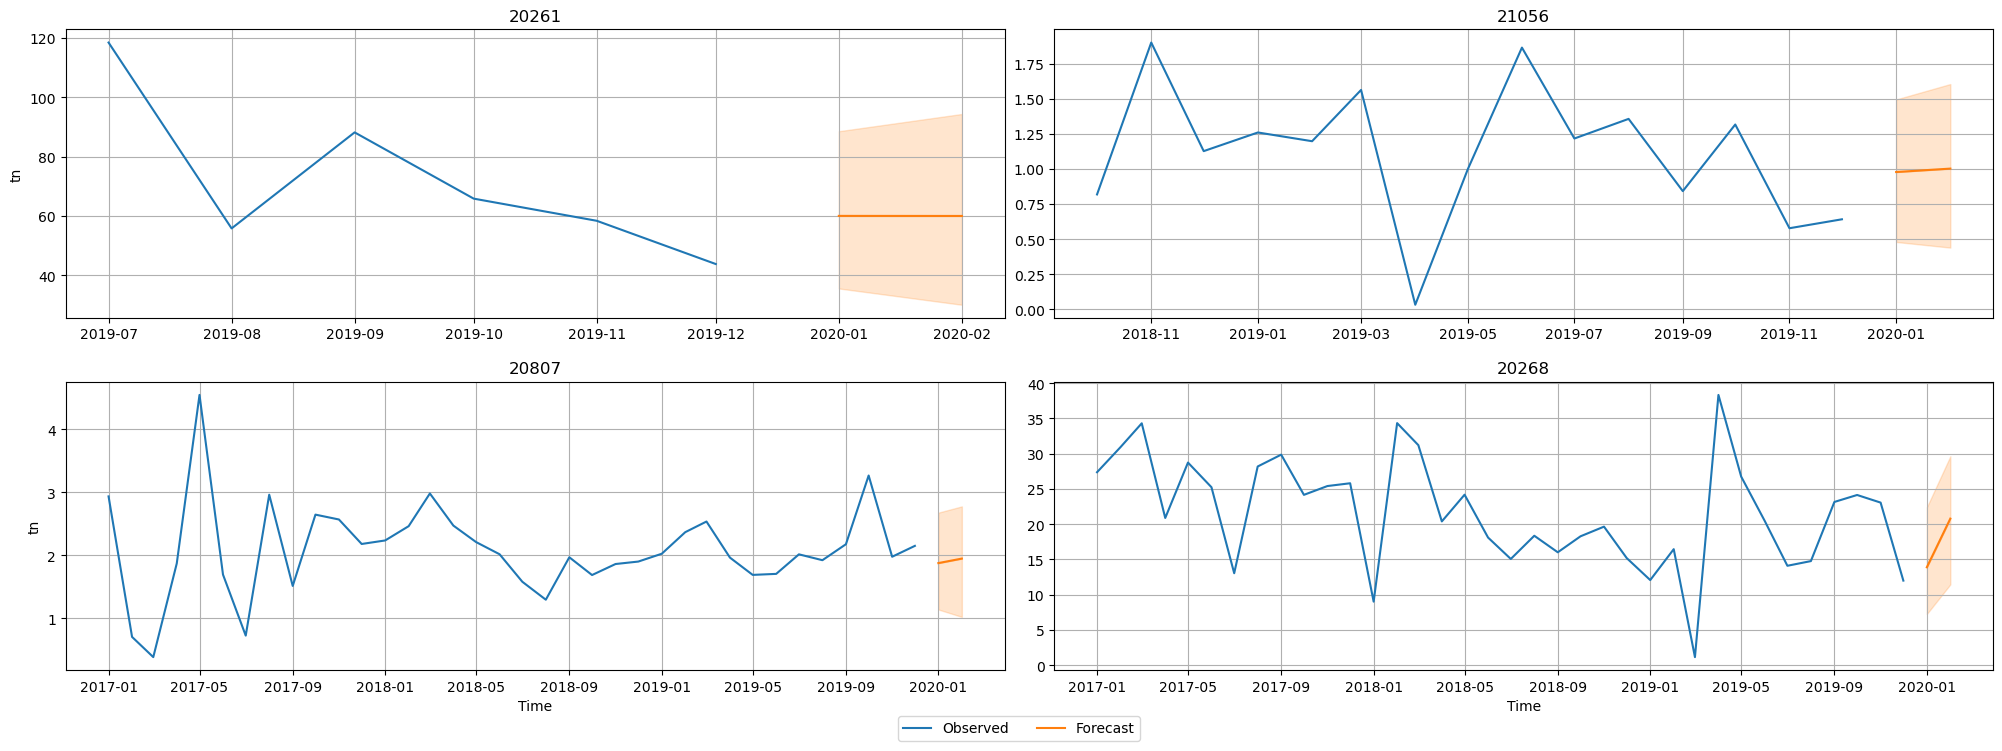

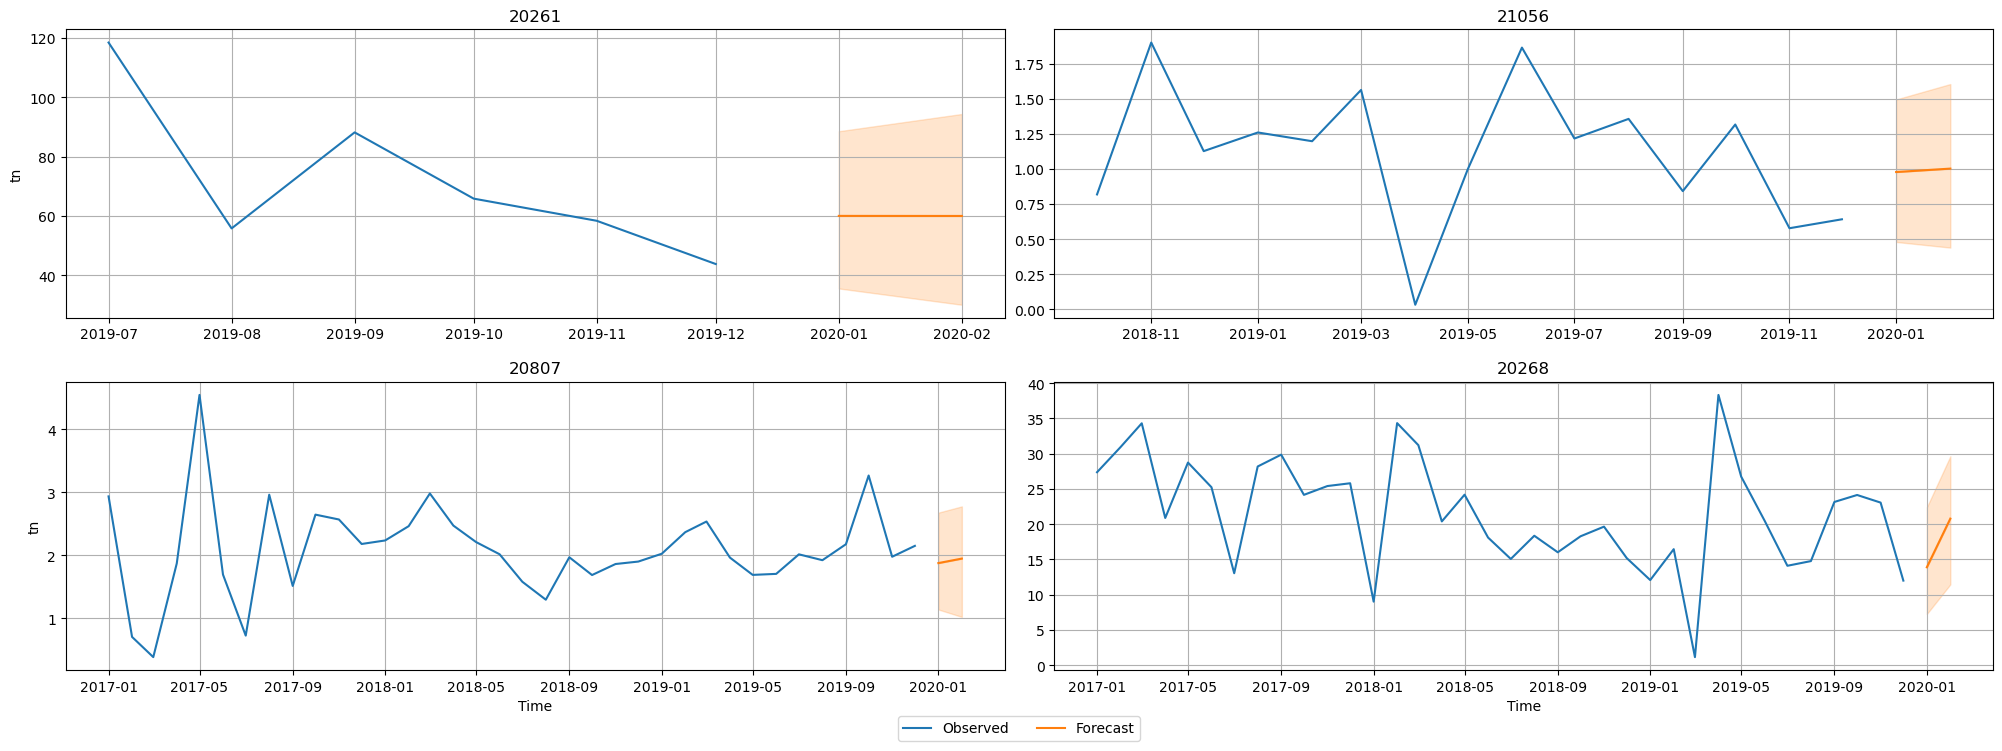

In [69]:
predictor.plot(ts_data, forecast, quantile_levels=[0.1, 0.9], max_history_length=200, max_num_item_ids=4)

In [70]:
# Extraer predicción media y filtrar febrero 2020
forecast_mean = forecast['mean'].reset_index()
print(forecast_mean.columns)

Index(['item_id', 'timestamp', 'mean'], dtype='object')


In [71]:
# Tomar solo item_id y la predicción 'mean'
resultado = forecast['mean'].reset_index()[['item_id', 'mean']]
resultado.columns = ['product_id', 'tn']

# Filtrar solo febrero 2020
resultado = forecast['mean'].reset_index()
resultado = resultado[resultado['timestamp'] == '2020-02-01']

# Renombrar columnas
resultado = resultado[['item_id', 'mean']]
resultado.columns = ['product_id', 'tn']


In [72]:
resultado

,product_id,tn
1,20001,1303.631371
3,20002,1052.922860
5,20003,679.411269
7,20004,506.437419
9,20005,498.931952
...,...,...
1551,20962,3.161497
1553,20975,2.826470
1555,20995,2.500369
1557,21087,0.915960


In [73]:
# 💾 7. Guardar archivo
resultado.to_csv("../data/autogluon_202002_exo_lhv1.csv", index=False)
resultado.head()

,product_id,tn
1,20001,1303.631371
3,20002,1052.922860
5,20003,679.411269
7,20004,506.437419
9,20005,498.931952
